In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('eventlog_large.csv', sep=';')
df.head()

,Case_ID,Activity,User,Timestamp
0,1,a,u2,2016-04-15 08:41:28
1,1,b,u3,2016-04-18 12:55:01
2,2,a,u2,2016-04-18 20:40:14
3,1,d,u5,2016-04-19 07:22:59
4,2,b,u4,2016-04-21 22:42:39


In [3]:
#Nodes dataframe for process flow
df_node = df.copy()
df_node = df_node[['Case_ID','Activity','Timestamp','User']]
df_node['Timestamp'] = pd.to_datetime(df_node['Timestamp'])
df_node = df_node.sort_values(by=['Case_ID','Timestamp','Activity'],ascending=True).reset_index(drop=True)

df_node

,Case_ID,Activity,Timestamp,User
0,1,a,2016-04-15 08:41:28,u2
1,1,b,2016-04-18 12:55:01,u3
2,1,d,2016-04-19 07:22:59,u5
3,1,e,2016-04-23 15:06:58,u7
4,1,f,2016-04-24 19:18:32,u7
...,...,...,...,...
45374,7549,d,2120-07-15 03:40:37,u5
45375,7549,g,2120-07-19 05:39:32,u6
45376,7549,e,2120-07-20 18:29:17,u7
45377,7549,f,2120-07-22 03:43:02,u7


In [4]:
sortnew1 = df_node.iloc[:-1,:]
sortnew2 = df_node.iloc[1:,:].reset_index(drop=True)
sortnew = pd.concat([sortnew1,sortnew2],axis=1)
sortnew.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortnew['Comparison'] = sortnew.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew = sortnew[sortnew['Comparison'] == True]

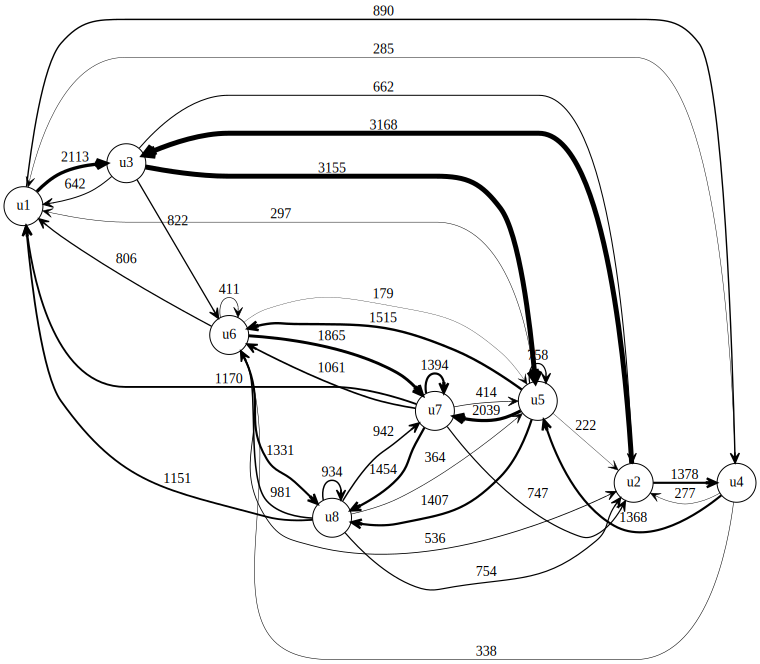

In [5]:
# Activity flow towards the users
sortnew1 = sortnew[['Case_ID', 'Start User','End user']]
countsort = sortnew1.groupby(['Start User','End user']).size()
newcountsort = countsort.to_frame(name='Weight').reset_index()
# newcountsort

G = graphviz.Digraph(format='jpeg')

G.attr(rankdir='LR')
G.attr('node', shape='circle')
G.attr('edge', arrowhead='vee')

max_node = 5
max_case_id = newcountsort['Weight'].max()

nodelist = []
for idx, row in newcountsort.iterrows():
    node1, node2, weight = [str(i) for i in row]
    
    if node1 not in nodelist:
        G.node(node1)
        nodelist.append(node2)
    if node2 not in nodelist:
        G.node(node2)
        nodelist.append(node2)
        
    G.edge(node1, node2, label = weight, penwidth=str(int(weight)/max_case_id*max_node))
    
G

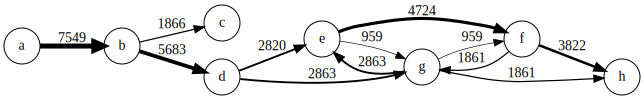

In [6]:
# Activity flow per activity
sortnew2 = sortnew[['Case_ID', 'Start Activity','End Activity']]
countsort2 = sortnew2.groupby(['Start Activity','End Activity']).size()
newcountsort1 = countsort2.to_frame(name='Weight').reset_index()
# newcountsort1

H = graphviz.Digraph(format='jpeg')

H.attr(rankdir='LR')
H.attr('node', shape='circle')
H.attr('edge')

max_node = 5
max_case_id = newcountsort1['Weight'].max()

nodelist2 = []
for idx, row in newcountsort1.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H.node(node22)
        nodelist2.append(node22)
        
    H.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
    
H
# .render('Control_Flow', view=True)

In [7]:
# Duration
sortnewtime = sortnew.copy()
sortnewtime['Start Time'] = pd.to_datetime(sortnewtime['Start Time'])
sortnewtime['End Time'] = pd.to_datetime(sortnewtime['End Time'])
sortnewtime['Duration'] = sortnewtime['End Time'] - sortnewtime['Start Time']

In [32]:
#Average Time per activity
sortnewtime2 = sortnewtime.copy()
sortnewtime2 = sortnewtime2[['Start Activity','End Activity','Duration']]
sortnewtime2['Duration'] = sortnewtime2['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime2 = sortnewtime2.groupby(['Start Activity','End Activity']).mean().reset_index()
sortnewtime2['Duration'] = round(sortnewtime2['Duration']/86400,2)
# sortnewtime2

Z = graphviz.Digraph(format='jpeg')

Z.attr(rankdir='LR')
Z.attr('node', shape='circle')
Z.attr('edge', arrowhead='vee', arrowtail='inv')

max_node = 5
max_case_id = sortnewtime2['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime2.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        Z.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        Z.node(node22)
        nodelist2.append(node22)
        
    Z.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node)) 

Z.render('Average time per activity', view=True)

'Average time per activity.jpeg'

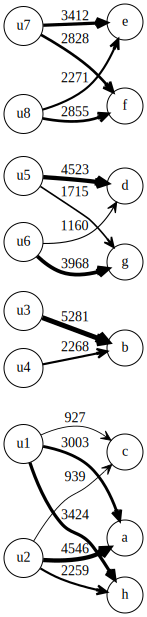

In [9]:
# Individual activities per user
iapu = df_node.copy()
iapu = iapu[['User','Activity']]
iapu = iapu.groupby(['User','Activity']).size()
iapu = iapu.to_frame(name='Weight').reset_index()
# iapu

ZA = graphviz.Digraph(format='jpeg')

ZA.attr(rankdir='LR')
ZA.attr('node', shape='circle')
ZA.attr('edge', arrowhead='vee', arrowtail='inv')

max_node = 5
max_case_id = iapu['Weight'].max()
nodelist2 = []
for idx, row in iapu.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        ZA.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        ZA.node(node22)
        nodelist2.append(node22)
        
    ZA.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
ZA

In [10]:
# Variants
variants = df_node.copy()
variants['Count'] = variants.groupby('Case_ID').cumcount()+1
variants = variants.pivot(index='Case_ID', columns='Count', values='Activity')
variants_col = variants.columns
variants = variants.fillna('X')
variants = variants.astype('str')
variants['Trace'] = variants.apply(lambda x: ','.join(x),axis=1)
variants['Trace'] = variants['Trace'].apply(lambda x: x.replace(',X',''))
variants

Count,1,2,3,4,5,6,7,Trace
Case_ID,,,,,,,,
1,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
2,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
3,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
4,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"
5,a,b,c,X,X,X,X,"a,b,c"
...,...,...,...,...,...,...,...,...
7545,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
7546,a,b,d,e,f,g,h,"a,b,d,e,f,g,h"
7547,a,b,d,g,e,f,h,"a,b,d,g,e,f,h"


In [11]:
variants_num = variants[['Trace',1]].groupby(['Trace'], as_index=False).count()
variants_num = variants_num.sort_values(by=1, ascending=False).reset_index()
del variants_num['index']
variants_num = variants_num.reset_index()
variants_num['index'] = variants_num['index']+1
variants_num = variants_num.rename(columns={'index':'Variants',1:'No of occurance'})
variants_num

Count,Variants,Trace,No of occurance
0,1,"a,b,d,g,e,f,h",2863
1,2,"a,b,c",1866
2,3,"a,b,d,e,f,g,h",1861
3,4,"a,b,d,e,g,f,h",959


In [12]:
variant_merge = variants.copy()
variant_merge = variant_merge.reset_index()
variant_merge = variant_merge.merge(variants_num, on='Trace') #.reset_index()
variant_merge = variant_merge.sort_values(by=('Case_ID')).reset_index(drop=True)
variant_merge = variant_merge.drop(variants_col, axis=1)
variant_merge = variant_merge.drop(['No of occurance','Trace'], axis=1)

In [13]:
df_variants = df_node.copy()
df_variants = df_variants.merge(variant_merge, on='Case_ID')
df_variants

,Case_ID,Activity,Timestamp,User,Variants
0,1,a,2016-04-15 08:41:28,u2,3
1,1,b,2016-04-18 12:55:01,u3,3
2,1,d,2016-04-19 07:22:59,u5,3
3,1,e,2016-04-23 15:06:58,u7,3
4,1,f,2016-04-24 19:18:32,u7,3
...,...,...,...,...,...
45374,7549,d,2120-07-15 03:40:37,u5,1
45375,7549,g,2120-07-19 05:39:32,u6,1
45376,7549,e,2120-07-20 18:29:17,u7,1
45377,7549,f,2120-07-22 03:43:02,u7,1


In [14]:
# Variants Comparison
df_variants_1 = df_variants[df_variants['Variants'] == 1].reset_index().drop(['index','Variants'], axis=1)
df_variants_3 = df_variants[df_variants['Variants'] == 3].reset_index().drop(['index','Variants'], axis=1)
df_variants_4 = df_variants[df_variants['Variants'] == 4].reset_index().drop(['index','Variants'], axis=1)
df_variants_2 = df_variants[df_variants['Variants'] == 2].reset_index().drop(['index','Variants'], axis=1)

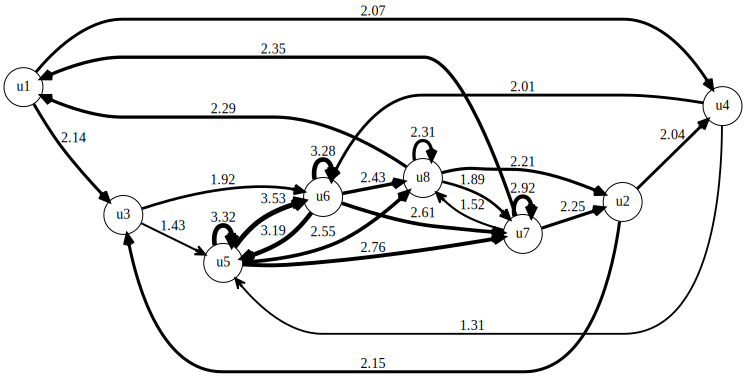

In [15]:
# Variant 1
sortnew11 = df_variants_1.iloc[:-1,:]
sortnew22 = df_variants_1.iloc[1:,:].reset_index(drop=True)
sortnew1 = pd.concat([sortnew11,sortnew22],axis=1)

sortnew1.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End User']
sortnew1['Comparison'] = sortnew1.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew1 = sortnew1[sortnew1['Comparison'] == True]

sortnewtime1 = sortnew1.copy()
sortnewtime1['Start Time'] = pd.to_datetime(sortnewtime1['Start Time'])
sortnewtime1['End Time'] = pd.to_datetime(sortnewtime1['End Time'])
sortnewtime1['Duration'] = sortnewtime1['End Time'] - sortnewtime1['Start Time']

sortnewtime21 = sortnewtime1.copy()
sortnewtime21 = sortnewtime21[['Start User','End User','Duration']]
sortnewtime21['Duration'] = sortnewtime21['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime21 = sortnewtime21.groupby(['Start User','End User']).mean().reset_index()
sortnewtime21['Duration'] = round(sortnewtime21['Duration']/86400,2)
# sortnewtime21

H1 = graphviz.Digraph(format='jpeg')

H1.attr(rankdir='LR')
H1.attr('node', shape='circle')
H1.attr('edge', arrowhead='vee', arrowtail='inv')

max_node = 5
max_case_id = sortnewtime21['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime21.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H1.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H1.node(node22)
        nodelist2.append(node22)
        
    H1.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node))
    
H1

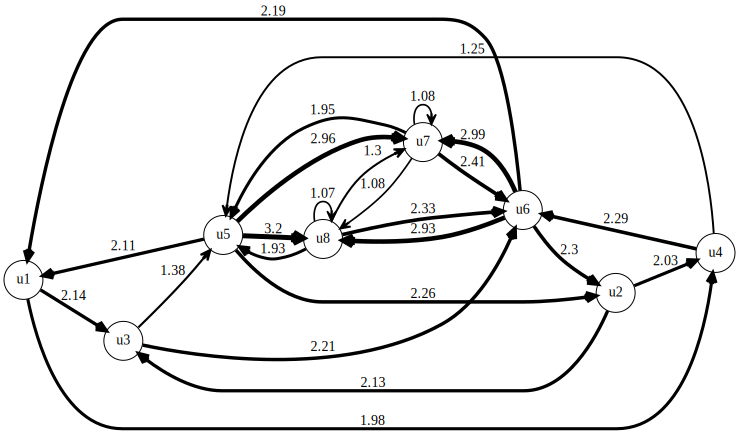

In [16]:
# Variant 2
sortnew13 = df_variants_3.iloc[:-1,:]
sortnew23 = df_variants_3.iloc[1:,:].reset_index(drop=True)
sortnew3 = pd.concat([sortnew13,sortnew23],axis=1)

sortnew3.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End User']
sortnew3['Comparison'] = sortnew3.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew3 = sortnew3[sortnew3['Comparison'] == True]

sortnewtime3 = sortnew3.copy()
sortnewtime3['Start Time'] = pd.to_datetime(sortnewtime3['Start Time'])
sortnewtime3['End Time'] = pd.to_datetime(sortnewtime3['End Time'])
sortnewtime3['Duration'] = sortnewtime3['End Time'] - sortnewtime3['Start Time']

sortnewtime23 = sortnewtime3.copy()
sortnewtime23 = sortnewtime23[['Start User','End User','Duration']]
sortnewtime23['Duration'] = sortnewtime23['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime23 = sortnewtime23.groupby(['Start User','End User']).mean().reset_index()
sortnewtime23['Duration'] = round(sortnewtime23['Duration']/86400,2)
# sortnewtime23

H3 = graphviz.Digraph(format='jpeg')

H3.attr(rankdir='LR')
H3.attr('node', shape='circle')
H3.attr('edge', arrowhead='vee', arrowtail='inv')

max_node = 5
max_case_id = sortnewtime23['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime23.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H3.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H3.node(node22)
        nodelist2.append(node22)
        
    H3.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node))

H3

In [31]:
#Activity duration
# df_plot = df_node.copy()
# df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])
# sns.set_style('whitegrid')
# sns.set_context('talk')
# fig, ax = plt.subplots(figsize=(15, 10))
# sns.scatterplot(x='Timestamp', y='Case_ID', data=df_plot, hue='Activity', hue_order=np.unique(df_plot['Activity']), s=500, alpha=1, ax=ax)
# ax.set_ylim(max(df_plot['Case_ID'])+1,0)
# ax.set_yticks((df_plot['Case_ID']).unique())
# plt.tight_layout()
# plt.show()

In [18]:
# Relative duration of activities

rdoa = df_node.copy()
rdoa = rdoa[['Case_ID','Activity','User','Timestamp']]
rdoa['Timestamp'] = pd.to_datetime(rdoa['Timestamp'])
rdoa['Cum_Duration'] = rdoa.groupby(['Case_ID'])['Timestamp'].transform(lambda x: (x-x.iloc[0]).dt.total_seconds())
rdoa['Cum_Duration'] = round(rdoa['Cum_Duration']/86400,0)
rdoa_plot = rdoa.copy()
rdoa_plot

,Case_ID,Activity,User,Timestamp,Cum_Duration
0,1,a,u2,2016-04-15 08:41:28,0.0
1,1,b,u3,2016-04-18 12:55:01,3.0
2,1,d,u5,2016-04-19 07:22:59,4.0
3,1,e,u7,2016-04-23 15:06:58,8.0
4,1,f,u7,2016-04-24 19:18:32,9.0
...,...,...,...,...,...
45374,7549,d,u5,2120-07-15 03:40:37,2.0
45375,7549,g,u6,2120-07-19 05:39:32,6.0
45376,7549,e,u7,2120-07-20 18:29:17,8.0
45377,7549,f,u7,2120-07-22 03:43:02,9.0


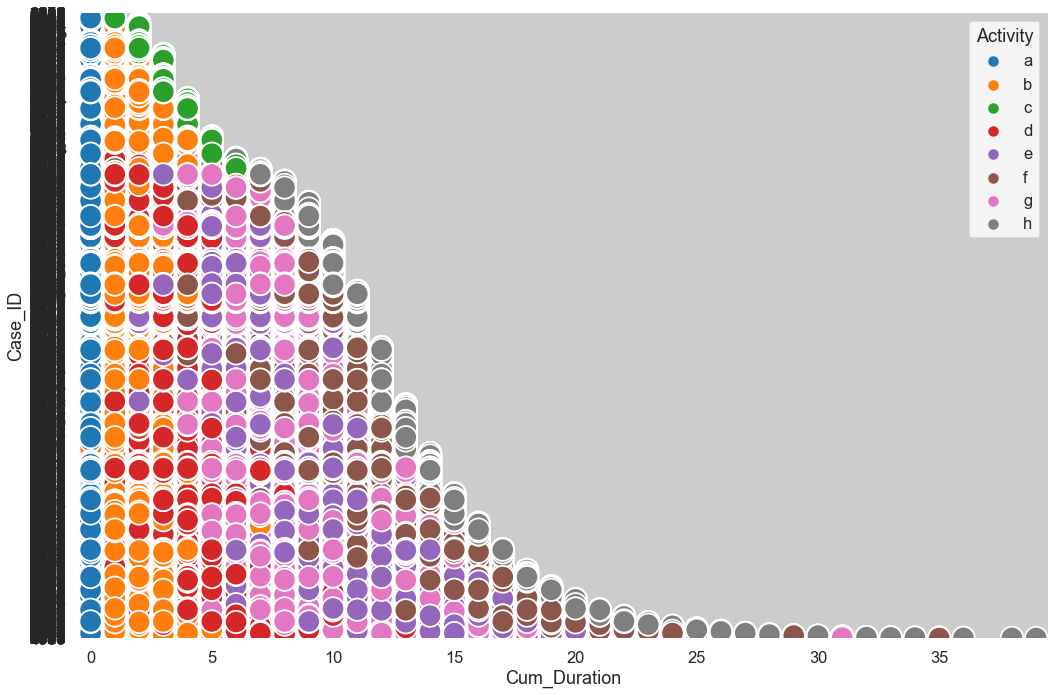

In [19]:
rdoa_plot['Case_ID'] = rdoa_plot['Case_ID'].astype(str)
df_max_dur = rdoa_plot.groupby('Case_ID')['Cum_Duration'].max().sort_values()
case_id_order = df_max_dur.index.astype(str)
rdoa_plot['Case_ID'] = pd.Categorical(rdoa_plot['Case_ID'], categories=case_id_order)

sns.set_style('whitegrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='Cum_Duration', y='Case_ID', data=rdoa_plot, hue='Activity', hue_order=np.unique(rdoa_plot['Activity']), s=500, alpha=1, ax=ax)
ax.set_xlim(-0.5, max(rdoa_plot['Cum_Duration']) + 0.5)
ax.set_ylim(len(case_id_order) - 0.5, -0.5)
for s in ax.spines:
    ax.spines[s].set_visible(False)
plt.tight_layout()
plt.show()

In [20]:
#Case duration
case_dur = df_node.copy()
case_dur['Timestamp'] = pd.to_datetime(case_dur['Timestamp'])
case_dur['Count'] = case_dur.groupby('Case_ID').cumcount()+1
case_dur = case_dur.pivot(index='Case_ID', columns='Count', values='Timestamp')
case_dur['Max_Time'] = case_dur.apply(max, axis=1)
case_dur_columns = case_dur.columns
case_dur['Case_Duration'] = case_dur['Max_Time'] - case_dur[1]
case_dur = case_dur.drop(case_dur_columns, axis=1)
case_dur

Count,Case_Duration
Case_ID,
1,11 days 01:19:08
2,12 days 21:52:04
3,5 days 09:21:46
4,15 days 05:23:54
5,1 days 21:47:22
...,...
7545,7 days 07:53:49
7546,10 days 01:14:52
7547,18 days 05:10:03


In [21]:
variants_num2 = variants_num.copy()
variants_num2['Trace'] = variants_num2['Trace'].apply(lambda x: x.replace(',','->'))
variants_num2["Percentage (%)"] = round(variants_num2['No of occurance']/variants_num2['No of occurance'].sum()*100,2)
variants_num2 = variants_num2.append(variants_num2.sum(numeric_only=True), ignore_index=True)
variants_num2

Count,Variants,Trace,No of occurance,Percentage (%)
0,1.0,a->b->d->g->e->f->h,2863.0,37.93
1,2.0,a->b->c,1866.0,24.72
2,3.0,a->b->d->e->f->g->h,1861.0,24.65
3,4.0,a->b->d->e->g->f->h,959.0,12.70
4,10.0,NaN,7549.0,100.00


In [22]:
activ = pd.read_csv('activities.csv', sep=';')
activ

,activity_ID,Activity
0,a,Fill out request
1,b,Approve request
2,c,Archive request
3,d,Order product
4,e,Receive product
5,f,Update stock
6,g,Handle payment
7,h,Close request


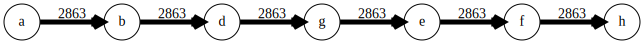

In [23]:
# Variant 1
sortnewvar1 = df_variants_1.iloc[:-1,:]
sortnewvar2 = df_variants_1.iloc[1:,:].reset_index(drop=True)
sortvar1 = pd.concat([sortnewvar1,sortnewvar2],axis=1)
sortvar1.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortvar1['Comparison'] = sortvar1.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortvar1 = sortvar1[sortvar1['Comparison'] == True]

sortnew1var1 = sortvar1[['Case_ID', 'Start Activity','End Activity']]
countsortvar1 = sortnew1var1.groupby(['Start Activity','End Activity']).size()
newcountsortvar1 = countsortvar1.to_frame(name='Weight').reset_index()
# newcountsortvar1

V1 = graphviz.Digraph(format='jpeg')

V1.attr(rankdir='LR')
V1.attr('node', shape='circle')
V1.attr('edge', arrowhead='vee')

max_node = 5
max_case_id = newcountsortvar1['Weight'].max()

nodelist2 = []
for idx, row in newcountsortvar1.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        V1.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        V1.node(node22)
        nodelist2.append(node22)
        
    V1.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node)) 

V1
# .render('Variant_One', view=True)

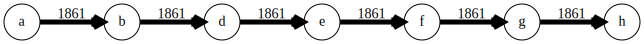

In [24]:
# Variant 3
sortnewvar12 = df_variants_3.iloc[:-1,:]
sortnewvar22 = df_variants_3.iloc[1:,:].reset_index(drop=True)
sortvar2 = pd.concat([sortnewvar12,sortnewvar22],axis=1)
sortvar2.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortvar2['Comparison'] = sortvar2.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortvar2 = sortvar2[sortvar2['Comparison'] == True]

sortnew1var2 = sortvar2[['Case_ID', 'Start Activity','End Activity']]
countsortvar2 = sortnew1var2.groupby(['Start Activity','End Activity']).size()
newcountsortvar2 = countsortvar2.to_frame(name='Weight').reset_index()
# newcountsortvar1

V2 = graphviz.Digraph(format='jpeg')

V2.attr(rankdir='LR')
V2.attr('node', shape='circle')
V2.attr('edge', arrowhead='vee')

max_node = 5
max_case_id = newcountsortvar2['Weight'].max()

nodelist2 = []
for idx, row in newcountsortvar2.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        V2.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        V2.node(node22)
        nodelist2.append(node22)
        
    V2.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node)) 

V2
# .render('Variant_Two', view=True)

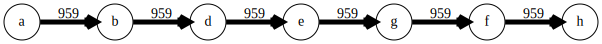

In [25]:
# Variant 4
sortnewvar14 = df_variants_4.iloc[:-1,:]
sortnewvar24 = df_variants_4.iloc[1:,:].reset_index(drop=True)
sortvar4 = pd.concat([sortnewvar14,sortnewvar24],axis=1)
sortvar4.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortvar4['Comparison'] = sortvar4.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortvar4 = sortvar4[sortvar4['Comparison'] == True]

sortnew1var4 = sortvar4[['Case_ID', 'Start Activity','End Activity']]
countsortvar4 = sortnew1var4.groupby(['Start Activity','End Activity']).size()
newcountsortvar4 = countsortvar4.to_frame(name='Weight').reset_index()
# newcountsortvar1

V4 = graphviz.Digraph(format='jpeg')

V4.attr(rankdir='LR')
V4.attr('node', shape='circle')
V4.attr('edge', arrowhead='vee')

max_node = 5
max_case_id = newcountsortvar4['Weight'].max()

nodelist2 = []
for idx, row in newcountsortvar4.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        V4.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        V4.node(node22)
        nodelist2.append(node22)
        
    V4.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node)) 

V4
# .render('Variant_Four', view=True)

In [26]:
var_dur = variants.copy()
var_dur_sum = case_dur.copy()
var_dur_sum = var_dur_sum.merge(var_dur, on='Case_ID').drop(variants_col, axis=1)
var_dur_sum['Case_Duration'] = var_dur_sum['Case_Duration'].apply(lambda x: round(x.total_seconds(),0))
var_dur_sum['Case_Duration'] = round(var_dur_sum['Case_Duration']/86400,0)
var_dur_sum = var_dur_sum.merge(variants_num, on='Trace').drop(['No of occurance'], axis=1)
var_dur_sum

Count,Case_Duration,Trace,Variants
0,11.0,"a,b,d,e,f,g,h",3
1,8.0,"a,b,d,e,f,g,h",3
2,15.0,"a,b,d,e,f,g,h",3
3,10.0,"a,b,d,e,f,g,h",3
4,10.0,"a,b,d,e,f,g,h",3
...,...,...,...
7544,17.0,"a,b,d,e,g,f,h",4
7545,19.0,"a,b,d,e,g,f,h",4
7546,7.0,"a,b,d,e,g,f,h",4
7547,11.0,"a,b,d,e,g,f,h",4


In [27]:
variant_summary = {'Variants':[1,2,3,4], 'Average': [round(var_dur_sum[var_dur_sum['Variants'] == 1]['Case_Duration'].mean(),2), round(var_dur_sum[var_dur_sum['Variants'] == 2]['Case_Duration'].mean(),2), round(var_dur_sum[var_dur_sum['Variants'] == 3]['Case_Duration'].mean(),2), round(var_dur_sum[var_dur_sum['Variants'] == 4]['Case_Duration'].mean(),2)], 'Minimum': [var_dur_sum[var_dur_sum['Variants'] == 1]['Case_Duration'].min(), var_dur_sum[var_dur_sum['Variants'] == 2]['Case_Duration'].min(), var_dur_sum[var_dur_sum['Variants'] == 3]['Case_Duration'].min(), var_dur_sum[var_dur_sum['Variants'] == 4]['Case_Duration'].min()], 'Maximum': [var_dur_sum[var_dur_sum['Variants'] == 1]['Case_Duration'].max(), var_dur_sum[var_dur_sum['Variants'] == 2]['Case_Duration'].max(), var_dur_sum[var_dur_sum['Variants'] == 3]['Case_Duration'].max(), var_dur_sum[var_dur_sum['Variants'] == 4]['Case_Duration'].max()],}
variant_summary = pd.DataFrame(variant_summary)
variant_summary

,Variants,Average,Minimum,Maximum
0,1,14.08,5.0,39.0
1,2,3.42,0.0,9.0
2,3,12.24,4.0,34.0
3,4,13.00,4.0,33.0


In [28]:
variants_num2.merge(variant_summary, on='Variants')

,Variants,Trace,No of occurance,Percentage (%),Average,Minimum,Maximum
0,1.0,a->b->d->g->e->f->h,2863.0,37.93,14.08,5.0,39.0
1,2.0,a->b->c,1866.0,24.72,3.42,0.0,9.0
2,3.0,a->b->d->e->f->g->h,1861.0,24.65,12.24,4.0,34.0
3,4.0,a->b->d->e->g->f->h,959.0,12.70,13.00,4.0,33.0


In [29]:
all_variant_summary = {'Variants':[var_dur_sum['Case_Duration'].count()], 'Average': [round(var_dur_sum['Case_Duration'].mean(),2)], 'Minimum': [var_dur_sum['Case_Duration'].min()], 'Maximum': [var_dur_sum['Case_Duration'].max()],}
all_variant_summary = pd.DataFrame(all_variant_summary)
all_variant_summary

,Variants,Average,Minimum,Maximum
0,7549,10.85,0.0,39.0


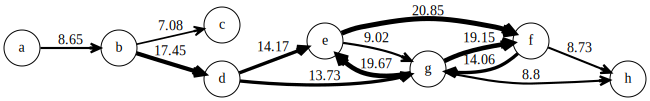

In [33]:
#Maximum Time per activity
sortnewtime2max = sortnewtime.copy()
sortnewtime2max = sortnewtime2max[['Start Activity','End Activity','Duration']]
sortnewtime2max['Duration'] = sortnewtime2max['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime2max = sortnewtime2max.groupby(['Start Activity','End Activity']).max().reset_index()
sortnewtime2max['Duration'] = round(sortnewtime2max['Duration']/86400,2)
# sortnewtime2

ZM = graphviz.Digraph(format='jpeg')

ZM.attr(rankdir='LR')
ZM.attr('node', shape='circle')
ZM.attr('edge', arrowhead='vee', arrowtail='inv')

max_node = 5
max_case_id = sortnewtime2max['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime2max.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        ZM.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        ZM.node(node22)
        nodelist2.append(node22)
        
    ZM.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node)) 

ZM
# .render('Average time per activity', view=True)

In [34]:
sortnewtime2max

,Start Activity,End Activity,Duration
0,a,b,8.65
1,b,c,7.08
2,b,d,17.45
3,d,e,14.17
4,d,g,13.73
5,e,f,20.85
6,e,g,9.02
7,f,g,14.06
8,f,h,8.73
9,g,e,19.67


In [ ]:
#TODO: Draw a scatter plot, x=timeline, y=Activity, hue=user to see the activities and the users